It looks like you might be running this notebook in Colab! If you want to enable GPU acceleration, ensure you select a GPU runtime in the top-right dropdown menu 🔥

# Train a model

> **FYI**, you can open this documentation as a [Google Colab notebook](https://colab.research.google.com/github/jla-gardner/graph-pes/blob/main/docs/source/quickstart/quickstart.ipynb) to follow along interactively

[graph-pes-train](https://jla-gardner.github.io/graph-pes/cli/graph-pes-train.html) provides a unified interface to train any [GraphPESModel](https://jla-gardner.github.io/graph-pes/models/root.html#graph_pes.GraphPESModel), including those packaged within [graph_pes.models](https://jla-gardner.github.io/graph-pes/models/root.html) and those defined by you, the user.

For more information on the ``graph-pes-train`` command, and the plethora of options available for specification in your ``config.yaml`` see the [CLI reference](https://jla-gardner.github.io/graph-pes/cli/graph-pes-train.html).

Below, we train a lightweight [NequIP](https://jla-gardner.github.io/graph-pes/models/many-body/nequip.html) model on the [C-GAP-17](https://jla-gardner.github.io/load-atoms/datasets/C-GAP-17.html) dataset.

## Installation


In [1]:
!pip install graph-pes

We now should have access to the ``graph-pes-train`` command. We can check this by running:

In [1]:
!graph-pes-train -h

usage: graph-pes-train [-h] [args ...]

Train a GraphPES model using PyTorch Lightning.

positional arguments:
  args        Config files and command line specifications. Config files
              should be YAML (.yaml/.yml) files. Command line specifications
              should be in the form my/nested/key=value. Final config is built
              up from these items in a left to right manner, with later items
              taking precedence over earlier ones in the case of conflicts.
              The data2objects package is used to resolve references and
              create objects directly from the config dictionary.

options:
  -h, --help  show this help message and exit

Copyright 2023-24, John Gardner


## Data definition

We use [load-atoms](https://jla-gardner.github.io/load-atoms/) to download and split the C-GAP-17 dataset into training, validation and test datasets:

In [2]:
import ase.io
from load_atoms import load_dataset

structures = load_dataset("C-GAP-17")
train, val, test = structures.random_split([0.8, 0.1, 0.1])

ase.io.write("train-cgap17.xyz", train)
ase.io.write("val-cgap17.xyz", val)
ase.io.write("test-cgap17.xyz", test)

Output()

We can visualise the kinds of structures we're training on using [load_atoms.view](https://jla-gardner.github.io/load-atoms/api/viz.html):


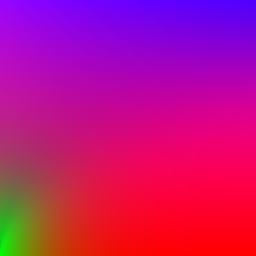

In [3]:
from load_atoms import view

view(train[0], show_bonds=True)

## Configuration

Great - now lets train a model. To do this, we have specified the following in our ``quickstart-cgap17.yaml`` file:

* the model architecture to instantiate and train, here [NequIP](https://jla-gardner.github.io/graph-pes/models/many-body/nequip.html). Note that we also include a [FixedOffset](https://jla-gardner.github.io/graph-pes/models/offsets.html#graph_pes.models.FixedOffset) component to account for the fact that the C-GAP-17 labels have an arbitrary offset.
* the data to train on, here the [C-GAP-17](https://jla-gardner.github.io/load-atoms/datasets/C-GAP-17.html) dataset we just downloaded
* the loss function to use, here a combination of a per-atom energy loss and a per-atom force loss
* and various other training hyperparameters (e.g. the learning rate, batch size, etc.)



We can download [this config file](https://raw.githubusercontent.com/jla-gardner/graph-pes/refs/heads/main/docs/source/quickstart/quickstart-cgap17.yaml) using wget:

In [4]:
%%bash

if [ ! -f quickstart-cgap17.yaml ]; then
    wget https://tinyurl.com/graph-pes-quickstart-cgap17 -O quickstart-cgap17.yaml
fi

## Training

You can see the output of the training run below in this [Weights and Biases dashboard](https://wandb.ai/jla-gardner/graph-pes-quickstart/runs/quickstart-cgap17).


In [6]:
!graph-pes-train quickstart-cgap17.yaml

[graph-pes INFO]: Started `graph-pes-train` at 2024-12-05 08:09:05.603
[graph-pes INFO]: Successfully parsed config.
[graph-pes INFO]: ID for this training run: quickstart-cgap17
[graph-pes INFO]: 
Output for this training run can be found at:
   └─ graph-pes-results/quickstart-cgap17
      ├─ logs/rank-0.log    # find a verbose log here
      ├─ model.pt           # the best model
      ├─ lammps_model.pt    # the best model deployed to LAMMPS
      └─ train-config.yaml  # the complete config used for this run

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
wandb: Currently logged in as: jla-gardner. Use `wandb login --relogin` to force relogin
wandb: Run data is saved locally in graph-pes-results/wandb/run-20241205_080908-quickstart-cgap17
wandb: Run `wandb offline` to turn off syncing.
wandb: Starting run quickstart-cgap17
wandb: ⭐️ View project at https://wandb.ai/jla-gardner/gr

# Model analysis

Let's load the best model from the above training run and evaluate it on the test dataset:

In [7]:
from graph_pes.models import load_model

best_model = load_model("graph-pes-results/quickstart-cgap17/model.pt")
best_model

AdditionModel(
  offset=FixedOffset(trainable=False),
  many-body=NequIP(
    (Z_embedding): AtomicOneHot(elements=['C'])
    (initial_node_embedding): PerElementEmbedding(dim=16, elements=[])
    (edge_embedding): SphericalHarmonics(1x1o -> 1x0e+1x1o+1x2e)
    (layers): UniformModuleList(
      (0): NequIPMessagePassingLayer(
        (pre_message_linear): Linear(16x0e -> 16x0e | 256 weights)
        (message_tensor_product): TensorProduct(16x0e x 1x0e+1x1o+1x2e -> 16x0e+16x1o+16x2e | 48 paths | 48 weights)
        (weight_generator): HaddamardProduct(
          (components): ModuleList(
            (0): Sequential(
              (0): Bessel(n_features=8, cutoff=3.700000047683716, trainable=True)
              (1): MLP(8 → 8 → 8 → 48, activation=SiLU())
            )
            (1): PolynomialEnvelope(cutoff=3.7, p=6)
          )
        )
        (aggregation): SumNeighbours()
        (non_linearity): Gate (28x0e+8x1o+4x2e -> 16x0e+8x1o+4x2e)
        (post_message_linear): Linear(16x

[GraphPESModel](https://jla-gardner.github.io/graph-pes/models/root.html#graph_pes.GraphPESModel) act on [AtomicGraph](https://jla-gardner.github.io/graph-pes/atomic_graph.html#graph_pes.AtomicGraph) objects. 

We can easily convert our [ase.Atoms](https://wiki.fysik.dtu.dk/ase/ase/atoms.html#module-ase.atoms) objects into [AtomicGraph](https://jla-gardner.github.io/graph-pes/data/atomic_graph.html#graph_pes.AtomicGraph) objects using [AtomicGraph.from_ase](https://jla-gardner.github.io/graph-pes/data/atomic_graph.html#graph_pes.AtomicGraph) (we could also use the [GraphPESCalculator](https://jla-gardner.github.io/graph-pes/utils.html#graph_pes.utils.calculator.GraphPESCalculator) to act directly on the [ase.Atoms](https://wiki.fysik.dtu.dk/ase/ase/atoms.html#module-ase.atoms) objects if we wanted to).

In [8]:
from graph_pes.atomic_graph import AtomicGraph

test_graphs = [
    AtomicGraph.from_ase(structure, cutoff=3.7) for structure in test
]
test_graphs[0]

AtomicGraph(
    atoms=64,
    edges=1124,
    has_cell=True,
    cutoff=3.7,
    properties=['energy', 'forces']
)

Our predictions look like this:

In [9]:
{
    k: v.shape
    for k, v in best_model.get_all_PES_predictions(test_graphs[0]).items()
}

{'energy': torch.Size([]),
 'forces': torch.Size([64, 3]),
 'local_energies': torch.Size([64]),
 'stress': torch.Size([3, 3]),
 'virial': torch.Size([3, 3])}

We can see from a single data point that our model has done a reasonable job of learning the potential:

In [10]:
best_model.predict_energy(test_graphs[0]), test_graphs[0].properties["energy"]

(tensor(-9994.0742), tensor(-9998.7080))

``graph-pes`` provides a few utility functions for visualising model performance:

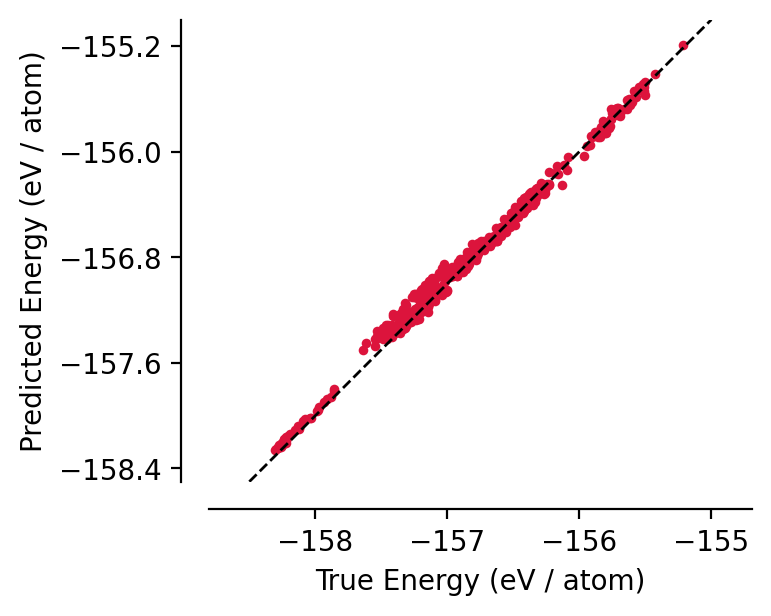

In [11]:
import matplotlib.pyplot as plt
from graph_pes.atomic_graph import divide_per_atom
from graph_pes.utils.analysis import parity_plot

%config InlineBackend.figure_format = 'retina'

parity_plot(
    best_model,
    test_graphs,
    property="energy",
    transform=divide_per_atom,
    units="eV / atom",
    lw=0,
    s=12,
    color="crimson",
)
plt.xlim(-158.5, -155)
plt.ylim(-158.5, -155);

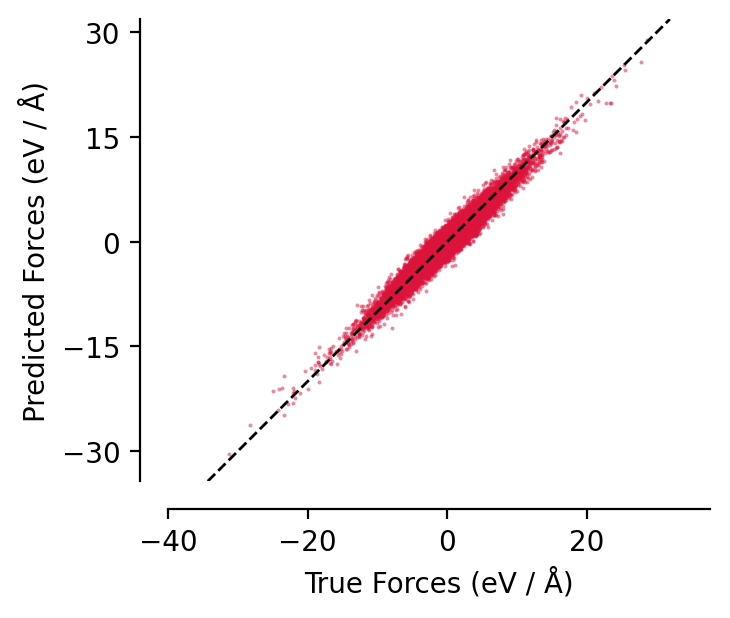

In [12]:
parity_plot(
    best_model,
    test_graphs,
    property="forces",
    units="eV / Å",
    lw=0,
    s=2,
    alpha=0.5,
    color="crimson"
)

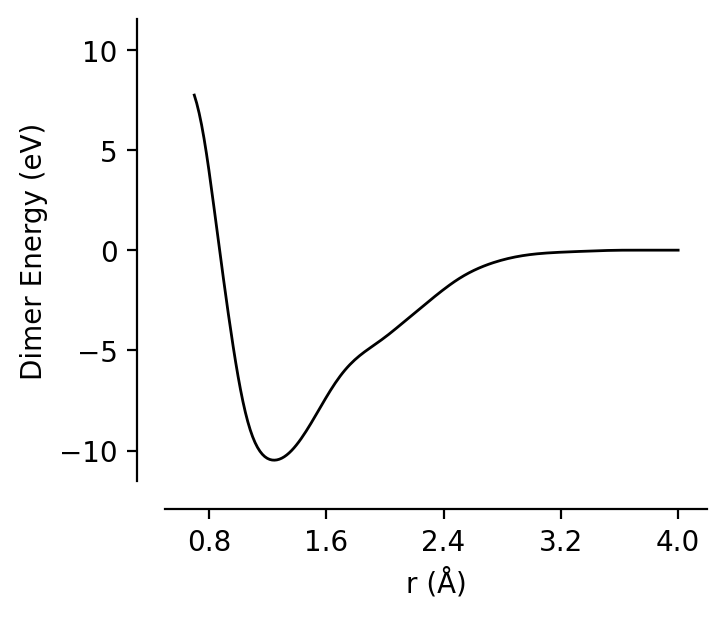

In [13]:
from graph_pes.utils.analysis import dimer_curve

dimer_curve(best_model, system="CC", units="eV", rmin=0.7, rmax=4.0);

# Fine-tuning

Let's now take the model we trained above, and fine-tune it on the [C-GAP-20U](https://jla-gardner.github.io/load-atoms/datasets/C-GAP-20U.html) dataset.

In [14]:
import ase.io
from load_atoms import load_dataset

structures = load_dataset("C-GAP-20U")
train, val, test = structures.random_split([0.8, 0.1, 0.1])

ase.io.write("train-cgap20u.xyz", train)
ase.io.write("val-cgap20u.xyz", val)
ase.io.write("test-cgap20u.xyz", test)

Output()

We can see that the ``C-GAP-20U`` dataset clearly has labels with a different arbitrary offset to the ``C-GAP-17`` dataset. 

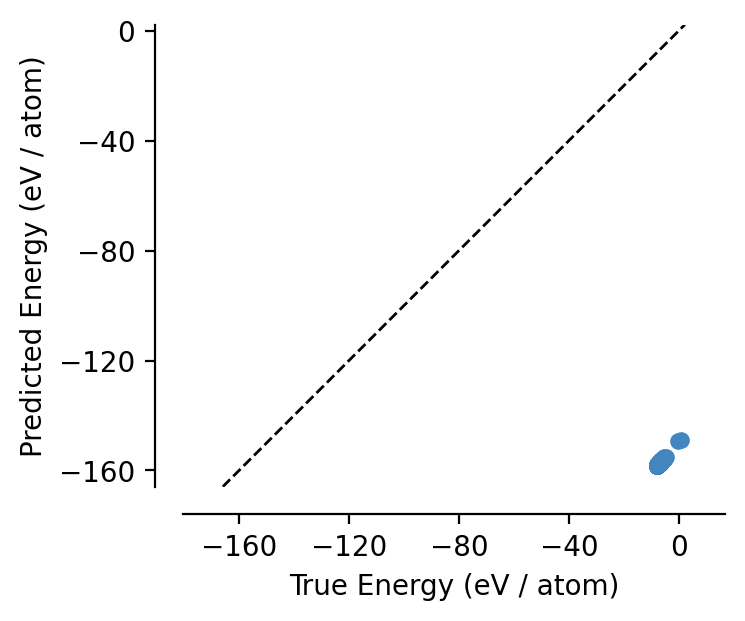

In [15]:
cgap20_test_graphs = [
    AtomicGraph.from_ase(structure, cutoff=3.7) for structure in test
]

parity_plot(
    best_model,
    cgap20_test_graphs,
    property="energy",
    transform=divide_per_atom,
    units="eV / atom",
)

In fact, the ``energy`` labels on ``C-GAP-20U`` are formation energies, and hence the offset we used above is no longer necessary:

In [16]:
from graph_pes.models import AdditionModel

assert isinstance(best_model, AdditionModel)
underlying_nequip = best_model["many-body"]
type(underlying_nequip)

graph_pes.models.e3nn.nequip.NequIP

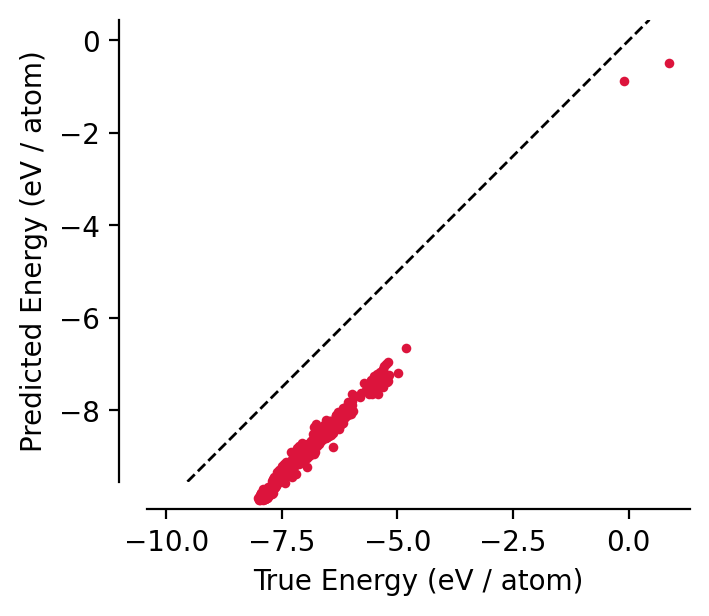

In [17]:
parity_plot(
    underlying_nequip,
    cgap20_test_graphs,
    property="energy",
    transform=divide_per_atom,
    units="eV / atom",
    lw=0,
    s=12,
    color="crimson"
)

Here we can see that the pre-trained [NequIP](https://jla-gardner.github.io/graph-pes/models/many-body/nequip.html) model is over-predicting the formation energies: this is to be expected as the DFT codes used to label ``C-GAP-17`` and ``C-GAP-20U`` are different.

## Training run

To fine-tune a `GraphPESModel`, we can use the same ``graph-pes-train`` command, but with a modified config file where we explicitly load in the model we want to fine-tune using either [load_model](https://jla-gardner.github.io/graph-pes/models/root.html#graph_pes.models.load_model) or [load_model_component](https://jla-gardner.github.io/graph-pes/models/root.html#graph_pes.models.load_model_component).

In [18]:
%%bash

if [ ! -f finetune-cgap20u.yaml ]; then
    wget https://tinyurl.com/graph-pes-finetune-cgap20u -O finetune-cgap20u.yaml
fi

In [19]:
!graph-pes-train finetune-cgap20u.yaml model/+load_model_component/path=graph-pes-results/quickstart-cgap17/model.pt

[graph-pes INFO]: Started `graph-pes-train` at 2024-12-05 08:19:40.426
[graph-pes INFO]: Successfully parsed config.
[graph-pes INFO]: ID for this training run: finetune-cgap20u
[graph-pes INFO]: 
Output for this training run can be found at:
   └─ graph-pes-results/finetune-cgap20u
      ├─ logs/rank-0.log    # find a verbose log here
      ├─ model.pt           # the best model
      ├─ lammps_model.pt    # the best model deployed to LAMMPS
      └─ train-config.yaml  # the complete config used for this run

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
wandb: Currently logged in as: jla-gardner. Use `wandb login --relogin` to force relogin
wandb: Run data is saved locally in graph-pes-results/wandb/run-20241205_081944-finetune-cgap20u
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run finetune-cgap20u
wandb: ⭐️ View project at https://wandb.ai/jla-gardner/graph-p

This fine-tuning process has aligned the model predictions with the ``C-GAP-20U`` formation energies:

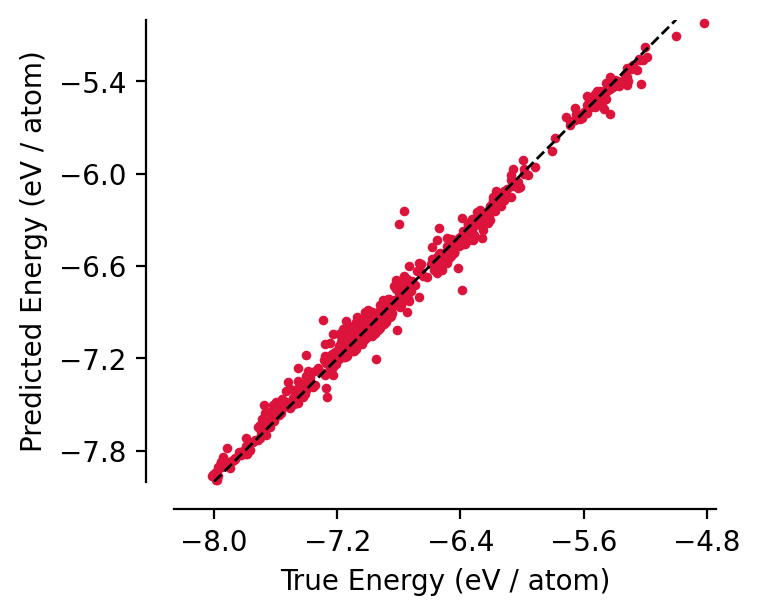

In [21]:
fine_tuned_model = load_model(
    "graph-pes-results/finetune-cgap20u/model.pt"
)
parity_plot(
    fine_tuned_model,
    cgap20_test_graphs,
    property="energy",
    transform=divide_per_atom,
    units="eV / atom",
    lw=0,
    s=12,
    color="crimson"
)
plt.xlim(-8, -5)
plt.ylim(-8, -5);